# Shopping Patterns & Basket Insights (EDA)

### Introduction & Purpose

**Purpose.** Get a decision-ready read on *when* people shop, *how often* they return, and *what* they repeatedly buy. This is descriptive groundwork that feeds segmentation, CRM timing, uplift tests, and forecasting.

**Questions we answer**
1. **Timing:** What hours/days are busiest?
2. **Rhythm:** Do reorders bunch around common cadences (e.g., 7/14/30 days)?
3. **Engagement:** How many orders do most customers place?
4. **Loyalty:** Which products dominate baskets and have high reorder rates?

**Why it matters (how it connects)**
- **CRM & activation:** 7–10 day and ~30 day peaks inform reminder windows and win-back flows.
- **Segmentation:** Engagement features (orders per user, cadence) feed customer clusters.
- **A/B & uplift:** High-loyalty SKUs + weak Week-1/Week-4 cohorts are prime targets.
- **Forecasting & anomalies:** Hour/day baselines and clean aggregates become regressors and monitors.

**Outputs**
- Compact QC snapshot (row counts, ranges, top nulls)  
- Visuals: hour/day, cadence, engagement, product loyalty  
- *(Optional)* Cohort retention heatmap  
- CSV artifacts for downstream notebooks

In [1]:
# Imports & Helpers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pathlib import Path

def qc_report(df, name, key=None, required=(), ranges=None):
    """Small QC summary for any dataframe."""
    ranges = ranges or {}
    out = {
        "rows": len(df),
        "cols": df.shape[1],
        "null_top5%": df.isna().mean().sort_values(ascending=False).head(5).round(4).to_dict()
    }
    if key:
        keys = key if isinstance(key, (list, tuple)) else [key]
        missing_keys = [c for c in keys if c not in df.columns]
        out["dup_key_rows"] = "n/a (missing keys)" if missing_keys else int(df.duplicated(subset=keys).sum())
    for col, (lo, hi) in ranges.items():
        if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
            bad = (~pd.to_numeric(df[col], errors="coerce").between(lo, hi)).sum()
            out[f"out_of_range({col})"] = int(bad)
    need = [c for c in required if c not in df.columns]
    if need: out["missing"] = need
    return name, out


In [2]:
# Load
def find_dir_upwards(dirname: str) -> Path:
    for p in [Path.cwd(), *Path.cwd().parents]:
        d = p / dirname
        if d.is_dir():
            return d
    raise FileNotFoundError(f"Couldn't find '{dirname}' from {Path.cwd()} upward.")

def read_csv_robust(path: Path) -> pd.DataFrame:
    # try common separators
    for sep in [",", ";", "|", "\t"]:
        try:
            df = pd.read_csv(path, sep=sep)
            if df.shape[1] > 1:
                return df
        except Exception:
            pass
    # fallback: single-column weirdness -> split on underscores
    df = pd.read_csv(path, header=None)
    if df.shape[1] == 1:
        df = df[0].str.split("_", expand=True)
    return df

DATA = find_dir_upwards("datasets")
CLEAN = DATA / "clean"

if (CLEAN / "orders_clean.csv").exists():
    orders = pd.read_csv(CLEAN / "orders_clean.csv")
    op      = pd.read_csv(CLEAN / "order_products_clean.csv")
else:
    # raw / original files (your names may vary)
    orders = read_csv_robust(DATA / "instacart_orders.csv")
    op      = read_csv_robust(DATA / "order_products.csv")

prod_path = DATA / "products.csv"
products  = read_csv_robust(prod_path) if prod_path.exists() else pd.DataFrame()

# normalize column names to a standard set 
def rename_first_match(df, target, candidates):
    for c in candidates:
        if c in df.columns:
            if c != target:
                df = df.rename(columns={c: target})
            return df
    return df

# orders
orders = rename_first_match(orders, "order_id",              ["order_id","orderid","id","order"])
orders = rename_first_match(orders, "user_id",               ["user_id","userid","customer_id","uid","shopper_id","user"])
orders = rename_first_match(orders, "order_dow",             ["order_dow","dow","order_day"])
orders = rename_first_match(orders, "order_hour_of_day",     ["order_hour_of_day","order_hour","hour"])
orders = rename_first_match(orders, "order_number",          ["order_number","sequence","seq"])
orders = rename_first_match(orders, "days_since_prior_order",["days_since_prior_order","days_since_last","dslo"])

# order_products
op = rename_first_match(op, "order_id",          ["order_id","orderid","id","order"])
op = rename_first_match(op, "product_id",        ["product_id","productid","pid"])
op = rename_first_match(op, "reordered",         ["reordered","is_reorder","reorder"])
op = rename_first_match(op, "add_to_cart_order", ["add_to_cart_order","cart_pos","atco"])

# dtypes (best effort)
for c in ["order_id","user_id","product_id","order_number","add_to_cart_order","order_dow","order_hour_of_day"]:
    if c in orders.columns: orders[c] = pd.to_numeric(orders[c], errors="coerce")
    if c in op.columns:     op[c]     = pd.to_numeric(op[c], errors="coerce")

print("Loaded:", orders.shape, op.shape, ("products empty" if products.empty else products.shape))

Loaded: (478967, 6) (4544317, 5) (49694, 4)


In [3]:
# Compact QC
qc = []
qc.append(qc_report(
    orders, "orders", key=["order_id"],
    required=["order_id","user_id","order_number","order_dow","order_hour_of_day","days_since_prior_order"],
    ranges={"order_hour_of_day": (0,23), "order_dow": (0,6)}
))
qc.append(qc_report(
    op, "order_products", key=["order_id","product_id"],
    required=["order_id","product_id","reordered"]
))
if not products.empty:
    # gently align product_id/product_name if columns are named differently
    cols = {c.lower(): c for c in products.columns}
    pid   = cols.get("product_id")  or next((c for c in products.columns if "product" in c.lower() and "id" in c.lower()), None)
    pname = cols.get("product_name") or next((c for c in products.columns if "name" in c.lower()), None)
    if pid and pname:
        products = products.rename(columns={pid:"product_id", pname:"product_name"})
    qc.append(qc_report(products, "products", key=["product_id"], required=["product_id","product_name"]))

display(pd.DataFrame(dict(qc)).T)

,rows,cols,null_top5%,dup_key_rows,out_of_range(order_hour_of_day),out_of_range(order_dow)
orders,478967,6,"{'days_since_prior_order': 0.0602, 'order_id':...",15,0,0
order_products,4544317,5,"{'order_id': 0.0, 'product_id': 0.0, 'add_to_c...",146,NaN,NaN
products,49694,4,"{'product_name': 0.0253, 'product_id': 0.0, 'a...",0,NaN,NaN


#### Compact QC
- **What this shows** A quick health check so downstream stats aren’t “garbage in → garbage out.”
We confirm row counts, duplicate keys, basic value ranges (order_hour_of_day ∈ 0–23, order_dow ∈ 0–6), and the most-missing columns.
- **How to use** it. If dup_key_rows > 0 or any out-of-range counts > 0, fix those before trusting results; otherwise proceed.

## When do people shop? (hour/day)

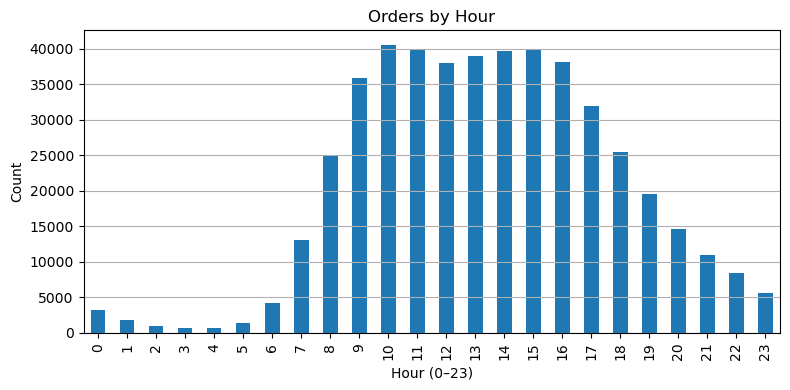

In [4]:
# Order by Hours 
plt.figure(figsize=(8,4))
orders["order_hour_of_day"].value_counts().sort_index().plot(kind="bar")
plt.title("Orders by Hour")
plt.xlabel("Hour (0–23)")
plt.ylabel("Count")
plt.grid(axis="y"); plt.tight_layout(); plt.show()

- **What this shows** -  Total orders across the 24-hour day.
- **Read it** - Traffic climbs mid-morning, peaks from ~10:00–16:00, and is minimal overnight.
- **Why it matters** -  Schedule promos and in-app placements when shoppers are present; staff picking/delivery for the peak window.

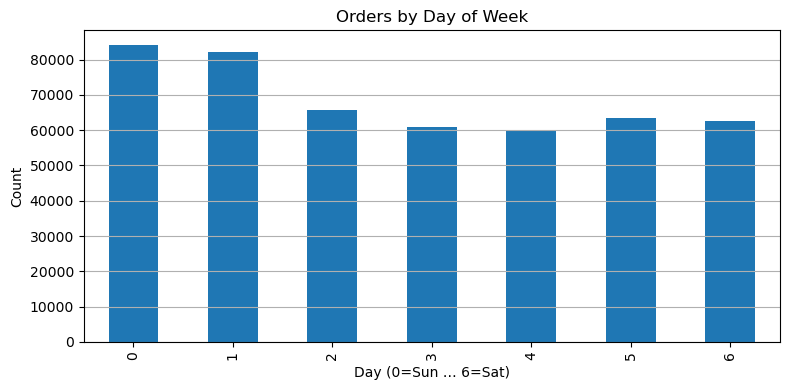

In [5]:
#Order by Day of Week 
plt.figure(figsize=(8,4))
orders["order_dow"].value_counts().sort_index().plot(kind="bar")
plt.title("Orders by Day of Week")
plt.xlabel("Day (0=Sun … 6=Sat)")
plt.ylabel("Count")
plt.grid(axis="y"); plt.tight_layout(); plt.show()

- **What this shows** -  Weekly pattern of order volume.
- **Read it** - Sunday & Monday lead; Thursday is the softest day.
- **Why it matters** - Front-load replenishment and reminder messages for weekend/early-week demand; test price/offer elasticity on slower days.

### Purchase rhythm (days since prior order)

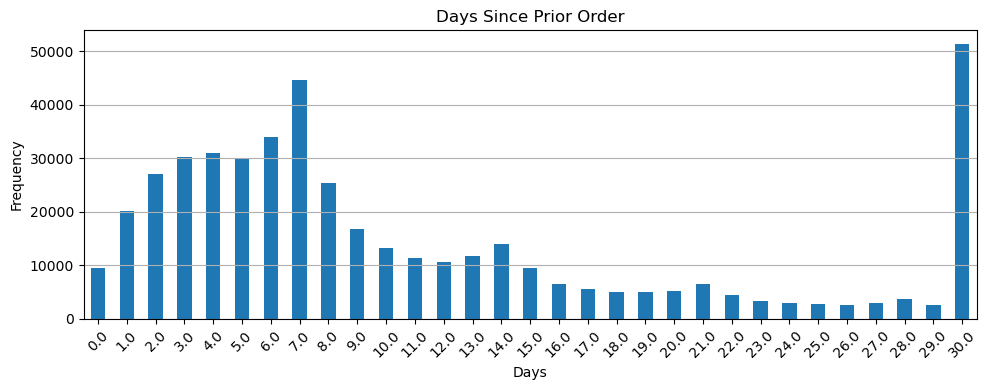

In [6]:
#Purchase rhythm (days since prior order)
plt.figure(figsize=(10,4))
(orders["days_since_prior_order"].dropna()
       .value_counts()
       .sort_index()
       .plot(kind="bar"))
plt.title("Days Since Prior Order")
plt.xlabel("Days"); plt.ylabel("Frequency")
plt.xticks(rotation=45); plt.grid(axis="y"); plt.tight_layout(); plt.show()

- **What this shows** - Distribution of time-to-next order.
- **Read it** - Clear bumps around 7/14/30 days—typical weekly/monthly rhythms—plus a long tail of infrequent shoppers.
- **Why it matters** - Use a T+7–10 day reminder as the primary nudge and a ~30-day win-back variant for stragglers.

### Customer engagement (orders per user)

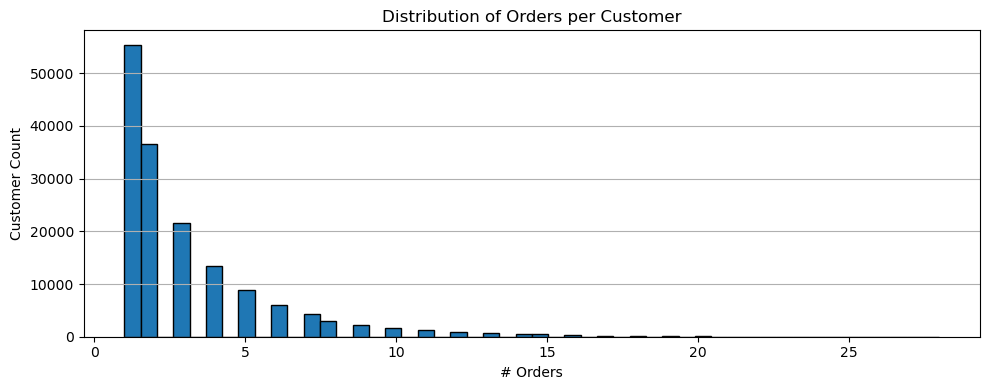

In [7]:
# Customer engagement (orders per user)
orders_per_user = orders.groupby("user_id")["order_id"].nunique()
plt.figure(figsize=(10,4))
plt.hist(orders_per_user, bins=50, edgecolor="black")
plt.title("Distribution of Orders per Customer")
plt.xlabel("# Orders"); plt.ylabel("Customer Count")
plt.grid(axis="y"); plt.tight_layout(); plt.show()

- **What this shows** - How many orders customers place.
- **Read it** - Highly skewed: many users at 1–2 orders; a long-tail of loyal power users.
- **Why it matters** -  Activation is the key problem (convert first-timers to 2nd order); consider loyalty tiers/subscriptions for the tail.

In [8]:
# Product loyalty (top products & reorder rate) — safe join
# aggregate at product level
prod_stats = (op.groupby("product_id")
                .agg(total_orders=("reordered","count"),
                     reorders=("reordered","sum"))
                .assign(reorder_rate=lambda d: d.reorders / d.total_orders)
                .reset_index())

# attach product names if available; else "(unknown)"
if not products.empty and {"product_id","product_name"}.issubset(products.columns):
    # align key dtypes before merging
    prod_stats["product_id"] = pd.to_numeric(prod_stats["product_id"], errors="coerce").astype("Int64")
    products["product_id"]   = pd.to_numeric(products["product_id"],   errors="coerce").astype("Int64")
    prod_stats = prod_stats.merge(products[["product_id","product_name"]], on="product_id", how="left")
else:
    prod_stats["product_name"] = "(unknown)"

top_by_volume = prod_stats.sort_values("total_orders", ascending=False).head(20)[["product_name","total_orders"]]
top_by_rate   = (prod_stats.query("total_orders >= 50")
                           .sort_values("reorder_rate", ascending=False)
                           .head(20)[["product_name","reorder_rate","total_orders"]])

print("Top 20 by Order Volume")
display(top_by_volume)
print("\nTop 20 by Reorder Rate (min 50 orders)")
display(top_by_rate)


Top 20 by Order Volume


,product_name,total_orders
22808,Banana,66047
12025,Bag of Organic Bananas,53297
19370,Organic Strawberries,37035
20077,Organic Baby Spinach,33970
43270,Organic Hass Avocado,29773
43787,Organic Avocado,24689
43662,Large Lemon,21495
15364,Strawberries,20017
24047,Limes,19689
25556,Organic Whole Milk,19602



Top 20 by Reorder Rate (min 50 orders)


,product_name,reorder_rate,total_orders
44044,DanActive Vanilla Probiotic Dairy Drink,0.907692,65
30242,Lemon Lime Seltzer,0.893939,66
36458,Organic Raspberry Mate Energy Drink,0.892308,65
15984,Lo-Carb Energy Drink,0.888889,63
22943,Whole Wheat Multigrain Pop Cakes,0.886792,53
44091,Purified Water- 9.5pH+,0.877193,57
8483,Half And Half Ultra Pasteurized,0.876574,397
2450,Yerba Mate Sparkling Classic Gold,0.871345,171
43291,Ultra-Purified Water,0.868293,205
1046,Wheat Sandwich Bread,0.863946,147


#### Top 20 Most Ordered Products (by volume)

- **What this shows** - SKUs that dominate order lines.
- **Read it** -  Everyday staples (e.g., bananas, greens, milk) lead.
- **Why it matters** - Protect availability/price and feature these items prominently; they anchor many baskets.

#### Top 20 by Reorder Rate (min 50 orders)

- **What this shows** -  Items customers re-buy most consistently.
- **Read it** -  Several SKUs have very high reorder rates (80–100%) once purchased.
- **Why it matters** -  Great candidates for “Buy Again,” bundle cross-sells, and auto-refill prompts.

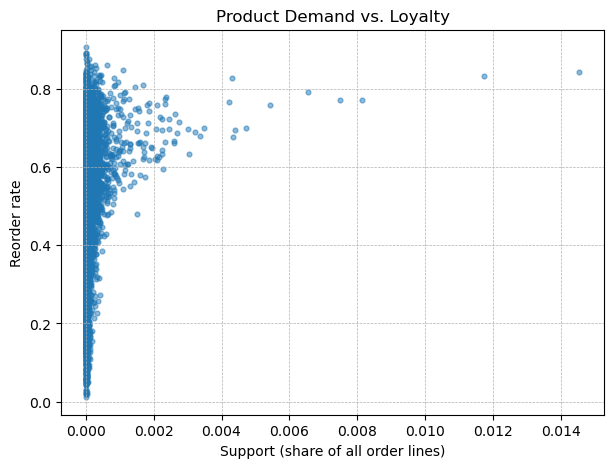

In [12]:
# Build product-level metrics: support + reorder_rate
assert {"product_id","reordered"}.issubset(op.columns), "order_products (op) needs product_id & reordered"

pm = (op.groupby("product_id")
        .agg(total_lines=("product_id","size"),
             reorders=("reordered","sum"))
        .assign(
            reorder_rate=lambda d: d.reorders / d.total_lines,
            support_pct=lambda d: d.total_lines / d.total_lines.sum()
        ))

# (optional) attach names if you loaded `products`
if "products" in globals() and not products.empty and {"product_id","product_name"}.issubset(products.columns):
    pm = (pm.reset_index()
            .merge(products[["product_id","product_name"]], on="product_id", how="left")
            .set_index("product_id"))

# (optional) filter out ultra-rare items for a cleaner plot
pm_plot = pm.query("total_lines >= 50").copy() if "total_lines" in pm.columns else pm.copy()

#plot

plt.figure(figsize=(7,5))
plt.scatter(pm_plot["support_pct"], pm_plot["reorder_rate"], s=12, alpha=0.5)
plt.xlabel("Support (share of all order lines)")
plt.ylabel("Reorder rate")
plt.title("Product Demand vs. Loyalty")
plt.grid(True, axis="both", linestyle="--", linewidth=0.5)
plt.show()

#### Product Demand vs. Loyalty (scatter)

- **What this shows**. Each dot = product; x = share of all order lines (“support”), y = reorder rate.
- **Read it:**
    - Upper-right = heroes (popular & loyal) → protect, feature, bundle.
    - Upper-left = niche loyal → targeted recommendations.
    - Lower-right = popular but low loyalty → price/quality issues? investigate.

**Why it matters** Prioritizes merchandising and testing focus by product quadrant.

#### Cohort Retention — Weekly Repeat Rates

***What & why*** We group users by the week of their first order (the “cohort”) and track what fraction of each cohort places another order in week k after that first purchase. Reading across a row shows how quickly that cohort repeats this is a direct lens on early retention and habit formation.

***How to read it***

- Darker cells = higher repeat rate.

- Week 1 reflects immediate stickiness after the first purchase.

- Week 4 is a common checkpoint for habit formation (monthly cadence).

- The diagonal fade indicates churn; flat or dark diagonals suggest stable habits.

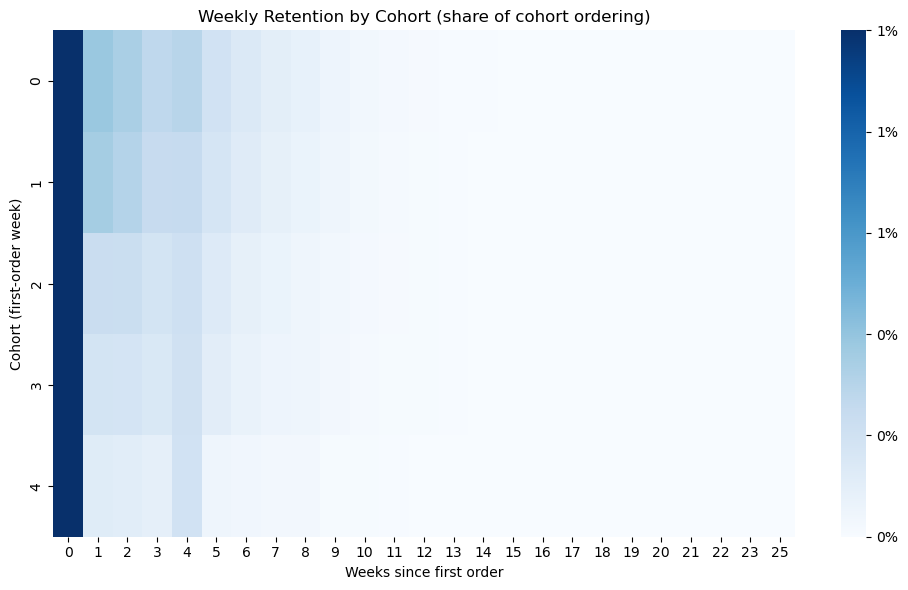

In [13]:
# Cohort retention (weekly)
coh = orders[["user_id","order_id","order_number","days_since_prior_order"]].copy()
coh["days_since_prior_order"] = pd.to_numeric(coh["days_since_prior_order"], errors="coerce").fillna(0)
coh = coh.sort_values(["user_id","order_number"])
coh["day"]   = coh.groupby("user_id")["days_since_prior_order"].cumsum()
coh["week"]  = (coh["day"] // 7).astype(int)
coh["cohort_week"]        = coh.groupby("user_id")["week"].transform("min")
coh["weeks_since_signup"] = coh["week"] - coh["cohort_week"]

ret_counts  = coh.groupby(["cohort_week","weeks_since_signup"])["user_id"].nunique().unstack(fill_value=0)
cohort_size = ret_counts.get(0).replace(0, np.nan)
retention   = (ret_counts.T / cohort_size).T

plt.figure(figsize=(10,6))
sns.heatmap(retention, cmap="Blues", cbar_kws={"format": "%.0f%%"})
plt.title("Weekly Retention by Cohort (share of cohort ordering)")
plt.xlabel("Weeks since first order"); plt.ylabel("Cohort (first-order week)")
plt.tight_layout(); plt.show()

***Figure*** Weekly retention by cohort. Read across each row to see how quickly cohorts decay; week-1 and week-4 are the key checkpoints.


- **What & why** Users grouped by the week of their first order; each cell = percent of that cohort ordering again in week k.
- **How to read** Darker = better retention. Week-1 and Week-4 are key checkpoints (onboarding vs. habit formation).
- **Actions** If Week-1 is weak → fix first-order experience and reminders. If decay steep after Week-1 → add week-2/3 reinforcement flows.

## Findings & Actions

- **Shopping window:** Orders cluster 10:00–16:00; overnight is negligible.
    - **Action:** Schedule promos and in app placements in peak hours; align picking/delivery capacity.

- **Weekly rhythm:** Sunday/Monday peak; Thursday is softest.
    - **Action:** Send replenishment nudges before the weekend; test discounts or category spotlights on Thursdays.

- **Reorder cadence:**  Visible bumps at ~7/14/30 days.
    - **Action:** Primary reminder at T+7–10 days; add a ~30-day win back for dormant users.

- **Engagement:**  Majority have only 1–2 orders; long tail of loyal users.
    - **Action:**  Activation offers for first timers (free delivery, bundle credit); loyalty tiers for high order users.

- **Product loyalty:**  Staples dominate volume; several SKUs with 80–100% reorder rates.
    - **Action:** Feature “Buy Again,” bundle high loyalty staples with adjacent categories, and protect stock/price.
    
- **Cohort retention (Week-1 & Week-4)** Early repeat sits around [W1%] at Week-1 and [W4%] at Week-4, then [steady/steep] fade.
    - **Action:** Trigger reminders at T+7–10 and T+28–30; if Week-1 is weak, fix onboarding (free delivery, welcome bundle); if Weeks 2–4 drop, add week-2/3 replenishment nudges and small loyalty credits; A/B cadence and measure lift in Week-4 retention.


**Why this matters**  These insights tell us who to target (first timers vs. loyalists), when to reach them (daily/weekly rhythms; T+7/30), and what to show (high loyalty SKUs). They feed segmentation (02), drivers of reorder (02 logit), forecasting (04), and uplift testing (05).

In [16]:
# Export artifacts for SQL / downstream notebooks
ART = Path("artifacts"); ART.mkdir(exist_ok=True)

# Daily volume for forecasting & anomaly detection
daily_orders = orders.groupby("order_number").size().rename("count").reset_index()
daily_orders.to_csv(ART / "daily_orders.csv", index=False)

# Product loyalty table
prod_stats.reset_index().to_csv(ART / "product_loyalty.csv", index=False)

# Top pairs (if computed)
try:
    pairs.to_csv(ART / "top_pairs_sample.csv", index=False)
except NameError:
    pass

print("Saved to artifacts/:", list(ART.glob("*.csv")))

Saved to artifacts/: [PosixPath('artifacts/daily_orders.csv'), PosixPath('artifacts/customer_segments.csv'), PosixPath('artifacts/product_loyalty.csv'), PosixPath('artifacts/product_metrics.csv'), PosixPath('artifacts/segment_profile_summary.csv')]
